In [19]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

In [20]:
from src.metadata_processing.load_data import *
from src.metadata_processing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.metadata_processing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from matplotlib import gridspec
import matplotlib
%matplotlib inline

In [21]:
# specify paths, where data is stored
path_to_info = PATH_TO_PROJECT + 'data/rat_info.csv'
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = ['arryn',]
#colonies = 'all'
dates = 'all'
experiments = 'all'
stages = ['traced and checked', 'labeled and checked']
stages = 'all'

In [22]:
info = load_info_file(path_to_info)
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                         stages = stages, experiments = experiments)
filters_mask = filters_mask & (recs_metadata['ratids'].apply(lambda x: len(x) > 4 ))
recs_metadata = recs_metadata[filters_mask].reset_index(drop=True)
print(recs_metadata.shape[0])
sounds_metadata =  sounds_metadata = generate_sounds_metadata(recs_metadata, 
                                                              classes_to_drop=[],
                                                              max_sounds_per_class={},
                                                              min_sound_length=0,
                                                              max_sound_length=10000,
                                                              columns_to_copy=['date', 'colony'],
                                                              sr=22050, print_counts=False)

recs_dict = {}
txts_dict = {}
n = 0
for rec_name, rec_path in recs_metadata[['name', 'path']].values:
    print(rec_name)
    txt = pd.read_csv(rec_path + rec_name.replace('npy', 'txt'), sep='\t')
    rec = np.load(rec_path + rec_name)
    txts_dict[rec_name] = txt
    recs_dict[rec_name] = rec
    n += 1
    if n > 1:
        break

23
arryn_29-01-18_9423_9624_0000028.npy
arryn_29-01-18_0088_9469_0000034.npy


In [23]:
rec_name = np.random.choice(list(txts_dict.keys()))
rec = recs_dict[rec_name]
txt = txts_dict[rec_name]

In [24]:
from src.audiodata_processing.process_waves import process_waves, butter_highpass_filter, denoise_recording
from src.util import make_image

In [37]:
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 256, 'time_mask_smooth_ms': 8}

In [38]:
rec_denoised = denoise_recording(rec, 22050, **rec_denoising_params)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 8769.45it/s]


74.11200699999999 74.435997 softchirp
147.199997 147.412003 softchirp


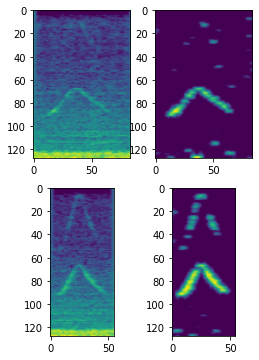

In [48]:
plt.figure(figsize=(4, 6))
inds = np.where(txt['cl'] != 'noise')[0]
np.random.shuffle(inds)
s, e, cl = (txt[['s', 'e', 'cl']].values[inds[0]])
print(s, e, cl)
s_ind = int(22050 * s)
e_ind = int(22050 * e)
sound = rec[s_ind: e_ind]
sound_f = rec_denoised[s_ind: e_ind]

plt.subplot(221)
plt.imshow(make_image(sound))
plt.subplot(222)
plt.imshow(make_image(sound_f))

s, e, cl = (txt[['s', 'e', 'cl']].values[inds[1]])
print(s, e, cl)
s_ind = int(22050 * s)
e_ind = int(22050 * e)
sound = rec[s_ind: e_ind]
sound_f = rec_denoised[s_ind: e_ind]

plt.subplot(223)
plt.imshow(make_image(sound))
plt.subplot(224)
plt.imshow(make_image(sound_f))

In [188]:
128 - 128 * 3000/22050 * 2

93.17006802721087

In [150]:
plt.figure(figsize=(12, 5))
plt.imshow(make_image(rec_start_f))

NameError: name 'rec_start_f' is not defined

<Figure size 864x360 with 0 Axes>

In [12]:
import librosa
import numpy as np
from skimage.transform import resize

def make_image(s, n_fft=512):
    D = np.abs(librosa.stft(s, n_fft=n_fft))
    D = np.flip(D, 0)
    output_shape = (int(D.shape[0] / 2), int(D.shape[1] * 1.5))
    im = librosa.amplitude_to_db(D, ) 
    return resize(im, output_shape)

In [13]:
def plot_random_sounds(rec, txt, n_fft=512):
    plt.figure(figsize=(8, 8))
    inds = np.where(txt['cl'] != 'noise')[0]
    np.random.shuffle(inds)
    inds = inds[:2]
    sounds = []
    for i in range(2):
        s, e = txt[['s', 'e']].values[inds[2 * i + j]]
        s_ind = int(22050 * s)
        e_ind = int(22050 * e)
        sound = rec[s_ind: e_ind]
        sounds.append(sound)
    ind = 0
    for s in sounds:
        for i in range(2):
            plt.subplot(2,2, ind + 1)
            plt.imshow(make_image(sound, n_fft))
            
            ind += 1
    